# Did you perceive the Tinnitus right now?
### Crosstab by season and country


In [1]:
# project location
p_loc = 'C:/Users/joa24jm/Documents/tinnitus-country/'

# add src to path so the noteboook can import utilities.py
import sys
sys.path.append('C:\\Users\\joa24jm\\Documents\\tinnitus-country\\src\\')

In [2]:
# imports
import pandas as pd
from d00_utils import utilities as u
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, ks_2samp
from scipy.stats import chi2_contingency, f_oneway

In [3]:
# read in df
df = pd.read_csv(p_loc + '/data/02_intermediate/merged_users.csv', index_col = 'Unnamed: 0',
                parse_dates = ['4', '9', 'fup_answer_from', 'bl_answer_from'],na_values = ['??.??.????', '27.02.2522']
                )

In [4]:
# number of countries
df.country.unique().shape

(111,)

In [5]:
# improve readability
df.rename(columns = {'question1':'Tinnitus_right_now'}, inplace = True)
df.Tinnitus_right_now.replace({0.0: 'No', 1.0: 'Yes'}, inplace = True)

In [6]:
# invert seasons for countries from the southern hemisphere
df['is_northern'] = df.country.apply(u.is_country_northern)

In [12]:
df['fup_season'] = df.apply(lambda x: u.get_season(x.fup_answer_from, x.is_northern), axis=1)

In [13]:
# get all countries with more than 30 users
u_treshold = 30

s = df.groupby('Country_Name').nunique()['user_id'] > u_treshold
u_countries = s[s].index.tolist()

# from these countries, get all with more than 300 answers
s = df[df.Country_Name.isin(u_countries)].groupby('Country_Name').size() > 300
countries = s[s].index.tolist()
countries

['Australia, Commonwealth of',
 'Austria, Republic of',
 'Belgium, Kingdom of',
 'Brazil, Federative Republic of',
 'Canada',
 'France, French Republic',
 'Germany, Federal Republic of',
 'Italy, Italian Republic',
 'Netherlands, Kingdom of the',
 'Norway, Kingdom of',
 'Spain, Kingdom of',
 'Sweden, Kingdom of',
 'Switzerland, Swiss Confederation',
 'United Kingdom of Great Britain & Northern Ireland',
 'United States of America']

## Check distribution for Norway

In [14]:
# check for norway users as they have 50% tinnitus  and 50% tinnitus NO
norway_filt = df['Country_Name'] == 'Norway, Kingdom of'

In [15]:
# how many users from Norway?
df[norway_filt].user_id.unique().shape

(42,)

In [16]:
for season in ['spring', 'summer', 'autumn', 'winter']:
    season_filt = df['fup_season'] == season
    print('Season\t\t', season)
    print('No. of users\t', df[season_filt & norway_filt].user_id.unique().shape[0])

Season		 spring
No. of users	 6
Season		 summer
No. of users	 11
Season		 autumn
No. of users	 16
Season		 winter
No. of users	 7


####  Norway has about 50% Tinnitus YES and 50 % Tinnitus NO reportings. How do the reportings vary over seasons?

In [17]:
pd.crosstab(df[df.Country_Name == 'Norway, Kingdom of'].fup_season, df.Tinnitus_right_now, normalize = 'index')


Tinnitus_right_now,No,Yes
fup_season,,
autumn,0.587361,0.412639
spring,0.417178,0.582822
summer,0.360577,0.639423
winter,0.702875,0.297125


## Check distributions for other countries in Europe

In [18]:
# sort tinnitus answers by country and season
ct = pd.crosstab([df[df.Country_Name.isin(countries)].Country_Name, df[df.Country_Name.isin(countries)].fup_season], df.Tinnitus_right_now,
                normalize='index')

In [19]:
# reindex in a logical order
ct = ct.reindex(['spring', 'summer', 'autumn', 'winter'], level = 'fup_season')

In [20]:
# find out the n_users and n_questionnaires for each country and season
ct['n_users'] = None
ct['n_questionnaires'] = None

for multi_index in ct.index:
    c = multi_index[0] # country
    s = multi_index[1] # season
    n_users = df[(df.Country_Name == c) & (df.fup_season == s)].nunique().user_id
    n_questionnaires = df[(df.Country_Name == c) & (df.fup_season == s)].shape[0]
    
    ct.loc[multi_index, 'n_users'] = n_users
    ct.loc[multi_index, 'n_questionnaires'] = n_questionnaires

# keep only countries that are above the thresholds for all seasons
ct = ct.loc[(ct.n_users > 30) & (ct.n_questionnaires > 300)]
s = ct.groupby('Country_Name').size() == 4
ct = ct.loc[s[s].index, :]
ct.to_csv(p_loc + 'results/01_tables/tinnitus_by_season.csv')
ct

Tinnitus_right_now                                                   No  \
Country_Name                                       fup_season             
Germany, Federal Republic of                       spring      0.223920   
                                                   summer      0.219304   
                                                   autumn      0.169706   
                                                   winter      0.235056   
Netherlands, Kingdom of the                        spring      0.352028   
                                                   summer      0.101167   
                                                   autumn      0.370302   
                                                   winter      0.374474   
Switzerland, Swiss Confederation                   spring      0.312107   
                                                   summer      0.250427   
                                                   autumn      0.348889   
                                                   winter      0.392694   
United Kingdom of Great Britain & Northern Ireland spring      0.156069   
                                                   summer      0.042770   
                                                   autumn      0.278978   
                                                   winter      0.341102   
United States of America                           spring      0.122672   
                                                   summer      0.188973   
                                                   autumn      0.100504   
                                                   winter      0.108846   

Tinnitus_right_now                                                  Yes  \
Country_Name                                       fup_season             
Germany, Federal Republic of                       spring      0.776080   
                                                   summer      0.780696   
                                                   autumn      0.830294   
                                                   winter      0.764944   
Netherlands, Kingdom of the                        spring      0.647972   
                                                   summer      0.898833   
                                                   autumn      0.629698   
                                                   winter      0.625526   
Switzerland, Swiss Confederation                   spring      0.687893   
                                                   summer      0.749573   
                                                   autumn      0.651111   
                                                   winter      0.607306   
United Kingdom of Great Britain & Northern Ireland spring      0.843931   
                                                   summer      0.957230   
                                                   autumn      0.721022   
                                                   winter      0.658898   
United States of America                           spring      0.877328   
                                                   summer      0.811027   
                                                   autumn      0.899496   
                                                   winter      0.891154   

Tinnitus_right_now                                            n_users  \
Country_Name                                       fup_season           
Germany, Federal Republic of                       spring         385   
                                                   summer         378   
                                                   autumn         460   
                                                   winter         387   
Netherlands, Kingdom of the                        spring          48   
                                                   summer          44   
                                                   autumn          78   
                                         

In [24]:
c = pd.crosstab(df.fup_season, df.Tinnitus_right_now, normalize = 0)
c

Tinnitus_right_now,No,Yes
fup_season,,
autumn,0.199406,0.800594
spring,0.213713,0.786287
summer,0.194159,0.805841
winter,0.249481,0.750519


In [16]:
table = np.array(c)
stat, p, dof, expected = chi2_contingency(table)
N = table.sum().sum()
print(f'X²({dof}, N={N}) = {round(stat,2)}, p={round(p,2)}')

X²(3, N=95446) = 216.19, p=0.0


In [17]:
ct.groupby('fup_season').describe()['Yes']

,count,mean,std,min,25%,50%,75%,max
fup_season,,,,,,,,
spring,5.0,0.766641,0.098232,0.647972,0.687893,0.776080,0.843931,0.877328
summer,5.0,0.839472,0.086221,0.749573,0.780696,0.811027,0.898833,0.957230
autumn,5.0,0.746324,0.115996,0.629698,0.651111,0.721022,0.830294,0.899496
winter,5.0,0.709566,0.118457,0.607306,0.625526,0.658898,0.764944,0.891154


#### Plot Tinnitus YES NO distribution by country and season

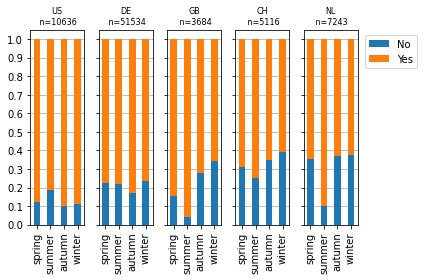

In [18]:
# generate the plot
fig, axes = plt.subplots(nrows = 1, ncols = int(ct.shape[0]/4), sharey=True)

countries = list(set([i[0] for i in ct.index]))
labels = ['spring', 'summer', 'autmn', 'winter']
country_labels = ['CH', 'DE', 'US', 'GB', 'NL']

for country2, ax, t in zip(countries, axes, country_labels):
    

    
    ct.loc[country2][['No', 'Yes']].plot.bar(stacked = True, ax = ax, zorder=3)
    
    # remove legend in each axis
    ax.get_legend().remove()
    
    # ax.set_xticklabels(labels = labels, rotation=90, fontsize=10)
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks(np.arange(0,1.1,.1))
    
    # set log scale and labels
    country_code = df[df.Country_Name.isin([country2])].country.unique().tolist()[0]
    n = '\n n=' + str(ct.loc[country2].n_questionnaires.sum())
    title = country_code + n
    
    ax.set_title(title, fontsize=8)
    
    # grid for better readability
    ax.grid(axis='y', zorder=0)
    
    
    # show values on bars
    # u.show_values_on_bars(ax, h_v = 'v', space = 1, normalize = True)
    
   
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.savefig(p_loc + 'results/07_plots/tinnitus_by_season.svg')





### Statistics

In [19]:
ct.describe()

Tinnitus_right_now,No,Yes
count,20.000000,20.000000
mean,0.234499,0.765501
std,0.108368,0.108368
min,0.042770,0.607306
25%,0.147720,0.656952
50%,0.229488,0.770512
75%,0.343048,0.852280
max,0.392694,0.957230


## Plot distribution by continent

In [20]:
ct = pd.crosstab([df.Continent_Name, df.fup_season], df.Tinnitus_right_now, normalize = 'index')
# reindex in a logical order
ct = ct.reindex(['spring', 'summer', 'autumn', 'winter'], level = 'fup_season')

In [21]:
# Number of answers per continent and season
ns = pd.crosstab(df.Continent_Name, df.Tinnitus_right_now, normalize = False).sum(axis = 1)

In [22]:
continents = ['Africa', 'Asia', 'Europe', 'Oceania', 'North America', 'South America']

Text(0.5, 1.05, 'Did you perceive the tinnitus right now?')

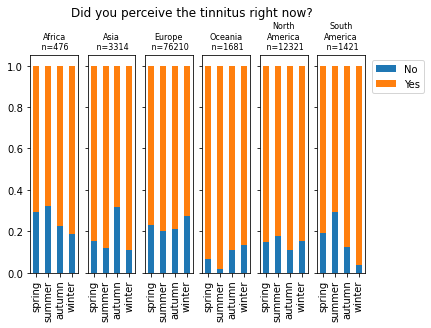

In [23]:
# generate the plot
fig, axes = plt.subplots(nrows = 1, ncols = len(continents), sharey=True)

labels = ['spring', 'summer', 'autmn', 'winter']

for continent, ax, t in zip(continents, axes, continents):
        
    ct.loc[continent][['No', 'Yes']].plot.bar(stacked = True, ax = ax)
    
    # remove legend in each axis
    ax.get_legend().remove()
    
    # ax.set_xticklabels(labels = labels, rotation=90, fontsize=10)
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    names = '\n'.join(t.split(' '))
    n = '\n n=' + str(ns[continent])
    title = names + n
    
    # set log scale and labels
    ax.set_title(title, fontsize=8)
    
    # show values on bars
    # u.show_values_on_bars(ax, h_v = 'v', space = 1, normalize = True)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Did you perceive the tinnitus right now?', y = 1.05)

In [24]:
pd.crosstab(df.fup_season, df.Tinnitus_right_now)

Tinnitus_right_now,No,Yes
fup_season,,
autumn,5081,20517
spring,4805,17546
summer,4532,18411
winter,6022,18532


### Tinnitus perception for users with more than 365 filled out questionnaires

In [25]:
# get all users with more than 365 daily questionnaires
users_365 = df.user_id.value_counts()[df.user_id.value_counts() > 365].index.tolist()
users_b365 = df.user_id.value_counts()[df.user_id.value_counts() <= 365].index.tolist()



In [26]:
# get season column
df['season'] = df.fup_answer_from.apply(u.get_season)

C:\Users\joa24jm\Documents\tinnitus-country\src\d00_utils\utilities.py:177: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  if start <= d <= end)


In [27]:
# shrink dataframe to users_365
sub_df = df[df.user_id.isin(users_365)]

In [28]:
# Occurence of Tinnitus for users_365
df.Tinnitus_right_now.value_counts(normalize = True)

Yes    0.785847
No     0.214153
Name: Tinnitus_right_now, dtype: float64

In [29]:
# Occurence of tinnitus by season for users_365
pd.crosstab(sub_df.season, sub_df.Tinnitus_right_now, normalize = 'index').style.format('{:,.2%}')


Tinnitus_right_now,No,Yes
season,,
autumn,15.26%,84.74%
spring,18.46%,81.54%
summer,16.06%,83.94%
winter,18.98%,81.02%


## How does the tinnitus occurence vary over the months for users_365?

In [30]:
# get the month of each answer
idx = sub_df.fup_answer_from.dt.month.index
sub_df.loc[idx, 'month'] = sub_df.fup_answer_from.dt.month.values.tolist()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [31]:
# show results for users_365
ct1 = pd.crosstab(sub_df.month, sub_df.Tinnitus_right_now, normalize = 'index')
ct1.rename(columns={0.0:'No', 1.0:'Yes'}, inplace = True)
ct1.style.format('{:,.2%}')

Tinnitus_right_now,No,Yes
month,,
1,20.54%,79.46%
2,18.70%,81.30%
3,20.95%,79.05%
4,15.90%,84.10%
5,16.15%,83.85%
6,21.72%,78.28%
7,22.59%,77.41%
8,9.78%,90.22%
9,10.26%,89.74%


## How does the tinnitus occruence vary between the months for all users?

In [32]:
df['month'] = df.fup_answer_from.dt.month

In [33]:
sub_df2 = df[df.user_id.isin(users_b365)]

ct2 = pd.crosstab(sub_df2.month, sub_df2.Tinnitus_right_now, normalize = 'index')
ct2.rename(columns = {0.0:'No', 1.0:'Yes'}, inplace = True)
ct2 = ct2.reindex(labels = np.arange(1, 13,1))
ct2.style.format('{:,.2%}')

Tinnitus_right_now,No,Yes
month,,
1,28.10%,71.90%
2,29.84%,70.16%
3,27.34%,72.66%
4,28.08%,71.92%
5,20.54%,79.46%
6,20.18%,79.82%
7,23.72%,76.28%
8,22.54%,77.46%
9,20.76%,79.24%


In [34]:
# overall mean as a baseline comparison
df.Tinnitus_right_now.value_counts(normalize = True)

Yes    0.785847
No     0.214153
Name: Tinnitus_right_now, dtype: float64

### Plot results side by side

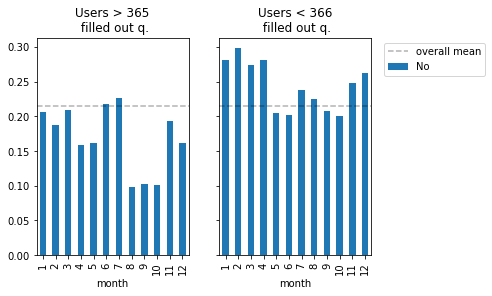

In [35]:
# instantiate plot element
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharey = True)

# create subplots with stacked bars
ct1['No'].plot.bar(stacked=False, ax = ax1)
ct2['No'].plot.bar(stacked=False, ax = ax2)

# remove legends per axis
# ax1.get_legend().remove()
# ax2.get_legend().remove()

# set title
ax1.set_title('Users > 365\n filled out q.')
ax2.set_title('Users < 366\n filled out q.')

# place a line to indicate the mean
val = df.Tinnitus_right_now.value_counts(normalize = True)['No']
ax1.axhline(y=val, linestyle='dashed', alpha=0.3, color='black', zorder=1, label = 'overall mean')
ax2.axhline(y=val, linestyle='dashed', alpha=0.3, color='black', zorder=1, label = 'overall mean')

# 

# put legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# save fig

In [36]:
# report for users_365
ct1.describe()

Tinnitus_right_now,No,Yes
count,12.000000,12.000000
mean,0.168530,0.831470
std,0.046496,0.046496
min,0.097787,0.774056
25%,0.144870,0.793540
50%,0.174359,0.825641
75%,0.206460,0.855130
max,0.225944,0.902213


In [37]:
# report for all users 
ct2.describe()

Tinnitus_right_now,No,Yes
count,12.000000,12.000000
mean,0.243590,0.756410
std,0.035356,0.035356
min,0.201072,0.701556
25%,0.207049,0.724752
50%,0.242753,0.757247
75%,0.275248,0.792951
max,0.298444,0.798928


### Is there a correlation of temperature and tinnitus data?

In [38]:
# read in the temperature df
t = pd.read_csv(p_loc + '/data/02_intermediate/temp_by_country-code_by_month.csv')

In [39]:
# rename columns to merge with other df
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
          'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
t.rename(columns = dict(zip(months, list(np.arange(1,13,1)))), inplace = True)

In [40]:
# prepare df for analysis
d = df[['fup_answer_from', 'Tinnitus_right_now','country']]

d.Tinnitus_right_now.replace({'No':0,'Yes':1}, inplace = True)

d['month'] = None
d.loc[:,'month'] = d.fup_answer_from.dt.month


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [41]:
# calculate the mean per country and month
d.groupby(['country','month']).mean()

# select only countries with more than 30 users and more than 300 questionnaires
countries = ['DE', 'NL', 'US', 'GB', 'CH']


In [62]:
# calculate the mean (= chance for tinnitus right now) per country and month
res = d[d.country.isin(countries)].groupby(['country','month']).agg(Mean=('Tinnitus_right_now', 'mean'), Std=('Tinnitus_right_now', 'std'))


In [63]:
res

Mean       Std
country month                    
CH      1.0    0.642857  0.479633
        2.0    0.642857  0.479843
        3.0    0.532258  0.499406
        4.0    0.615012  0.487183
        5.0    0.748201  0.434829
        6.0    0.779468  0.415000
        7.0    0.737013  0.440972
        8.0    0.712846  0.453005
        9.0    0.787062  0.409937
        10.0   0.684507  0.465368
        11.0   0.606911  0.488965
        12.0   0.660377  0.473988
DE      1.0    0.761525  0.426204
        2.0    0.731678  0.443152
        3.0    0.767672  0.422364
        4.0    0.760571  0.426795
        5.0    0.791527  0.406279
        6.0    0.778350  0.415393
        7.0    0.736199  0.440742
        8.0    0.801716  0.398753
        9.0    0.821909  0.382632
        10.0   0.829690  0.375937
        11.0   0.813694  0.389397
        12.0   0.870639  0.335651
GB      1.0    0.709480  0.454698
        2.0    0.692090  0.462282
        3.0    0.586885  0.493202
        4.0    0.721790  0.448554
        5.0    0.929530  0.256080
        6.0    0.906504  0.291720
        7.0    0.907563  0.290867
        8.0    0.989899  0.100248
        9.0    0.967532  0.177817
        10.0   0.969231  0.173360
        11.0   0.685714  0.465340
        12.0   0.515695  0.500878
NL      1.0    0.604631  0.489140
        2.0    0.616361  0.486615
        3.0    0.610370  0.488028
        4.0    0.664683  0.472570
        5.0    0.650735  0.477617
        6.0    0.678445  0.467901
        7.0    0.937956  0.241676
        8.0    0.950769  0.216683
        9.0    0.827214  0.378471
        10.0   0.740157  0.439125
        11.0   0.588235  0.492545
        12.0   0.632468  0.482290
US      1.0    0.891599  0.311027
        2.0    0.914554  0.279676
        3.0    0.843876  0.363217
        4.0    0.889279  0.314062
        5.0    0.895299  0.306495
        6.0    0.811388  0.391549
        7.0    0.755935  0.429735
        8.0    0.851107  0.356342
        9.0    0.931238  0.253298
        10.0   0.935629  0.245597
        11.0   0.915720  0.277939
        12.0   0.855368  0.351885

In [43]:
res

Tinnitus_right_now   tin_std
country month                              
CH      1.0              0.642857  0.479633
        2.0              0.642857  0.479843
        3.0              0.532258  0.499406
        4.0              0.615012  0.487183
        5.0              0.748201  0.434829
        6.0              0.779468  0.415000
        7.0              0.737013  0.440972
        8.0              0.712846  0.453005
        9.0              0.787062  0.409937
        10.0             0.684507  0.465368
        11.0             0.606911  0.488965
        12.0             0.660377  0.473988
DE      1.0              0.761525  0.426204
        2.0              0.731678  0.443152
        3.0              0.767672  0.422364
        4.0              0.760571  0.426795
        5.0              0.791527  0.406279
        6.0              0.778350  0.415393
        7.0              0.736199  0.440742
        8.0              0.801716  0.398753
        9.0              0.821909  0.382632
        10.0             0.829690  0.375937
        11.0             0.813694  0.389397
        12.0             0.870639  0.335651
GB      1.0              0.709480  0.454698
        2.0              0.692090  0.462282
        3.0              0.586885  0.493202
        4.0              0.721790  0.448554
        5.0              0.929530  0.256080
        6.0              0.906504  0.291720
        7.0              0.907563  0.290867
        8.0              0.989899  0.100248
        9.0              0.967532  0.177817
        10.0             0.969231  0.173360
        11.0             0.685714  0.465340
        12.0             0.515695  0.500878
NL      1.0              0.604631  0.489140
        2.0              0.616361  0.486615
        3.0              0.610370  0.488028
        4.0              0.664683  0.472570
        5.0              0.650735  0.477617
        6.0              0.678445  0.467901
        7.0              0.937956  0.241676
        8.0              0.950769  0.216683
        9.0              0.827214  0.378471
        10.0             0.740157  0.439125
        11.0             0.588235  0.492545
        12.0             0.632468  0.482290
US      1.0              0.891599  0.311027
        2.0              0.914554  0.279676
        3.0              0.843876  0.363217
        4.0              0.889279  0.314062
        5.0              0.895299  0.306495
        6.0              0.811388  0.391549
        7.0              0.755935  0.429735
        8.0              0.851107  0.356342
        9.0              0.931238  0.253298
        10.0             0.935629  0.245597
        11.0             0.915720  0.277939
        12.0             0.855368  0.351885

In [44]:
# write index to column
res['country'] = [t[0] for t in res.index]

In [45]:
# prepare t dataframe for merge
t = t.set_index('Code').drop(labels = 'Name', axis = 1)

In [46]:
t.loc[countries]

,1,2,3,4,5,6,7,8,9,10,11,12,Year
Code,,,,,,,,,,,,,
DE,1.100000,2.350000,5.750000,10.250000,14.750000,17.850000,20.150000,19.600000,15.250000,10.450000,5.800000,1.900000,10.450000
NL,3.400000,3.500000,6.100000,9.100000,12.900000,15.400000,17.600000,17.500000,14.700000,11.000000,7.100000,4.000000,10.200000
US,4.578846,6.505769,10.323077,14.780769,19.388462,23.584615,25.792308,25.271154,21.848077,16.176923,10.363462,5.540385,15.342308
GB,4.250000,4.500000,6.550000,8.400000,11.450000,14.300000,16.300000,16.100000,13.650000,10.350000,6.950000,4.450000,9.800000
CH,0.300000,1.300000,5.300000,8.800000,13.300000,16.400000,18.600000,18.000000,14.100000,9.900000,4.400000,1.400000,9.300000


In [47]:
# merge temperature with country and month and tinnitus occurence
res['temp'] = None
for month in np.arange(1,13,1):
    for cc in t.loc[countries].index:
        res.loc[(cc, month), 'temp'] = t.loc[cc, month]

In [48]:
res

Tinnitus_right_now   tin_std country       temp
country month                                                 
CH      1.0              0.642857  0.479633      CH        0.3
        2.0              0.642857  0.479843      CH        1.3
        3.0              0.532258  0.499406      CH        5.3
        4.0              0.615012  0.487183      CH        8.8
        5.0              0.748201  0.434829      CH       13.3
        6.0              0.779468  0.415000      CH       16.4
        7.0              0.737013  0.440972      CH       18.6
        8.0              0.712846  0.453005      CH       18.0
        9.0              0.787062  0.409937      CH       14.1
        10.0             0.684507  0.465368      CH        9.9
        11.0             0.606911  0.488965      CH        4.4
        12.0             0.660377  0.473988      CH        1.4
DE      1.0              0.761525  0.426204      DE        1.1
        2.0              0.731678  0.443152      DE       2.35
        3.0              0.767672  0.422364      DE       5.75
        4.0              0.760571  0.426795      DE      10.25
        5.0              0.791527  0.406279      DE      14.75
        6.0              0.778350  0.415393      DE      17.85
        7.0              0.736199  0.440742      DE      20.15
        8.0              0.801716  0.398753      DE       19.6
        9.0              0.821909  0.382632      DE      15.25
        10.0             0.829690  0.375937      DE      10.45
        11.0             0.813694  0.389397      DE        5.8
        12.0             0.870639  0.335651      DE        1.9
GB      1.0              0.709480  0.454698      GB       4.25
        2.0              0.692090  0.462282      GB        4.5
        3.0              0.586885  0.493202      GB       6.55
        4.0              0.721790  0.448554      GB        8.4
        5.0              0.929530  0.256080      GB      11.45
        6.0              0.906504  0.291720      GB       14.3
        7.0              0.907563  0.290867      GB       16.3
        8.0              0.989899  0.100248      GB       16.1
        9.0              0.967532  0.177817      GB      13.65
        10.0             0.969231  0.173360      GB      10.35
        11.0             0.685714  0.465340      GB       6.95
        12.0             0.515695  0.500878      GB       4.45
NL      1.0              0.604631  0.489140      NL        3.4
        2.0              0.616361  0.486615      NL        3.5
        3.0              0.610370  0.488028      NL        6.1
        4.0              0.664683  0.472570      NL        9.1
        5.0              0.650735  0.477617      NL       12.9
        6.0              0.678445  0.467901      NL       15.4
        7.0              0.937956  0.241676      NL       17.6
        8.0              0.950769  0.216683      NL       17.5
        9.0              0.827214  0.378471      NL       14.7
        10.0             0.740157  0.439125      NL       11.0
        11.0             0.588235  0.492545      NL        7.1
        12.0             0.632468  0.482290      NL        4.0
US      1.0              0.891599  0.311027      US   4.578846
        2.0              0.914554  0.279676      US   6.505769
        3.0              0.843876  0.363217      US  10.323077
        4.0              0.889279  0.314062      US  14.780769
        5.0              0.895299  0.306495      US  19.388462
        6.0              0.811388  0.391549      US  23.584615
        7.0              0.755935  0.429735      US  25.792308
        8.0              0.851107  0.356342      US  25.271154
        9.0              0.931238  0.253298      US  21.848077
        10.0             0.935629  0.245597      US  16.176923
        11.0             0.915720  0.277939      US  10.363462
        12.0             0.855368  0.351885      US   5.540385

### ANOVA to compare distribution of momentary tinnitus per country

In [49]:
samples = [np.array(res[res.country == c]['Tinnitus_right_now'].values) for c in countries]
s = dict(zip(countries, samples))

F, p = f_oneway(s['CH'], s['DE'], s['GB'], s['NL'], s['US'])
k = len(samples)
N = sum([len(s) for s in samples])

print(f'F({k-1}, {N-k})=',round(F, 2), ', p = ' , (round(p,5)))

F(4, 55)= 6.69 , p =  0.00018


#### p-value of oneway ANOVA is significant, so perform post-hoc Tukey test to find out which group differs

In [50]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=res['Tinnitus_right_now'], groups=res['country'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    CH     DE   0.1096 0.0874   -0.01 0.2293  False
    CH     GB   0.1194 0.0508 -0.0003  0.239  False
    CH     NL   0.0294    0.9 -0.0903  0.149  False
    CH     US   0.1951  0.001  0.0755 0.3148   True
    DE     GB   0.0097    0.9 -0.1099 0.1294  False
    DE     NL  -0.0803 0.3337 -0.1999 0.0394  False
    DE     US   0.0855 0.2726 -0.0342 0.2051  False
    GB     NL    -0.09 0.2259 -0.2096 0.0296  False
    GB     US   0.0758 0.3933 -0.0439 0.1954  False
    NL     US   0.1657 0.0023  0.0461 0.2854   True
---------------------------------------------------


Post-hoc Tukey reveals differences between NL-US and CH-US, Null-Hypothesis rejected at p=.05

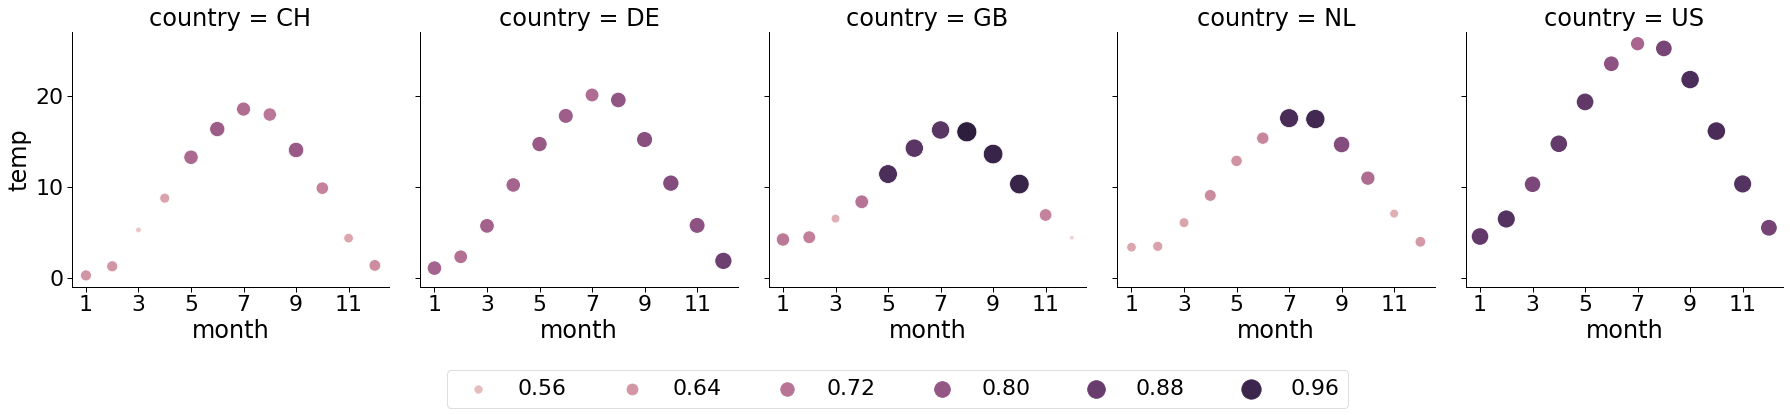

In [51]:
# convert temp to float
res.temp = res.temp.astype('float')

# set fontsize
sns.set_context("paper", font_scale=2.5)   

# plot results
g = sns.relplot(
    data=res, x="month", y="temp",
    col="country", size = 'Tinnitus_right_now', hue='Tinnitus_right_now',
    kind="scatter", sizes = (20,400), facet_kws=dict(legend_out=False)
    )

h,l = g.axes[0][0].get_legend_handles_labels()
g.axes[0][0].legend_.remove()
g.fig.legend(h,l, ncol=6, bbox_to_anchor=(0.75, -.05)) 

# set xticks and -labels correctly
ticks = np.arange(1, 13, 2)
for ax in g.axes.flat:
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)

plt.savefig(p_loc + 'results/07_plots/tinnitus_by_month_and_temp_and_country.svg')

In [52]:
# calculate correlations
for c in countries:
    x = res[res.country == c]['Tinnitus_right_now'].values
    y = res[res.country == c]['temp'].values
    print(c, '\t r:', '{:.2f}'.format(pearsonr(x,y)[0]), '\t p:', '{:.4f}'.format(pearsonr(x,y)[1]))


DE 	 r: -0.09 	 p: 0.7757
NL 	 r: 0.83 	 p: 0.0008
US 	 r: -0.41 	 p: 0.1809
GB 	 r: 0.86 	 p: 0.0004
CH 	 r: 0.72 	 p: 0.0087


### Does the tinnitus occurence vary throughout the year?

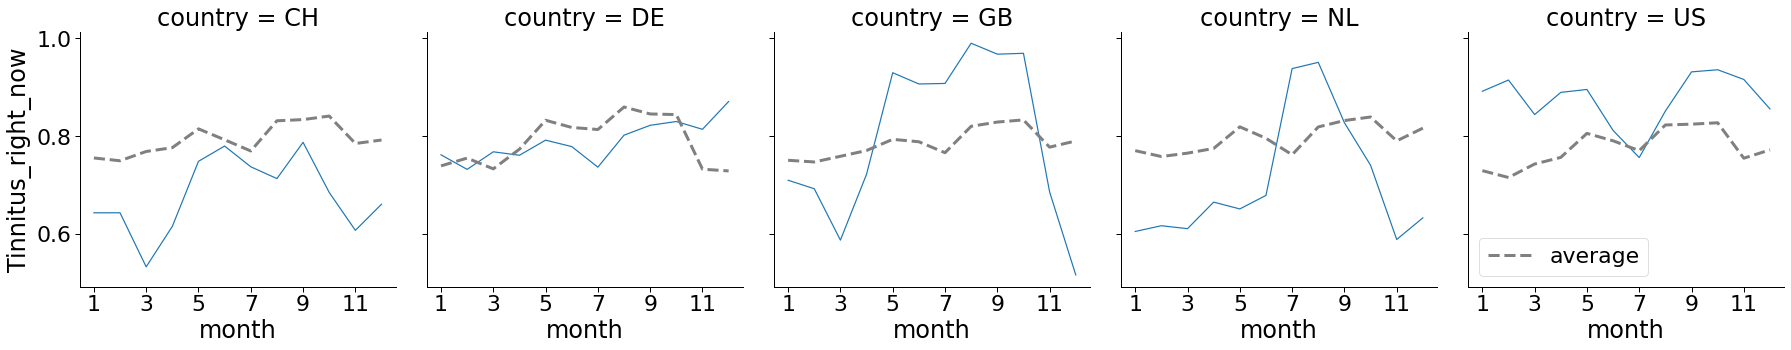

In [53]:
# set fontsize
sns.set_context("paper", font_scale=2.5)   

# plot results
g = sns.relplot(
    data=res, x="month", y="Tinnitus_right_now",
    col="country",
    kind="line", sizes = (20,400)
    )

# show the average for the whole df

for c, ax in g.axes_dict.items():
    ex_df = df[df.country != c]
    ex_df_ct = pd.crosstab(ex_df.month, ex_df.Tinnitus_right_now, normalize = 'index')['Yes']
    y = ex_df_ct.values
    x_avg = ex_df_ct.index
    ax.plot(x_avg, y, linestyle = 'dashed', color = 'grey', label = 'average', linewidth = 3)
    

# set xticks and -labels correctly
ticks = np.arange(1, 13, 2)
for ax in g.axes.flat:
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    
    
# add legend
plt.legend()

plt.savefig(p_loc + 'results/07_plots/tinnitus_by_month_and_country.svg')

In [54]:
res

Tinnitus_right_now   tin_std country       temp
country month                                                 
CH      1.0              0.642857  0.479633      CH   0.300000
        2.0              0.642857  0.479843      CH   1.300000
        3.0              0.532258  0.499406      CH   5.300000
        4.0              0.615012  0.487183      CH   8.800000
        5.0              0.748201  0.434829      CH  13.300000
        6.0              0.779468  0.415000      CH  16.400000
        7.0              0.737013  0.440972      CH  18.600000
        8.0              0.712846  0.453005      CH  18.000000
        9.0              0.787062  0.409937      CH  14.100000
        10.0             0.684507  0.465368      CH   9.900000
        11.0             0.606911  0.488965      CH   4.400000
        12.0             0.660377  0.473988      CH   1.400000
DE      1.0              0.761525  0.426204      DE   1.100000
        2.0              0.731678  0.443152      DE   2.350000
        3.0              0.767672  0.422364      DE   5.750000
        4.0              0.760571  0.426795      DE  10.250000
        5.0              0.791527  0.406279      DE  14.750000
        6.0              0.778350  0.415393      DE  17.850000
        7.0              0.736199  0.440742      DE  20.150000
        8.0              0.801716  0.398753      DE  19.600000
        9.0              0.821909  0.382632      DE  15.250000
        10.0             0.829690  0.375937      DE  10.450000
        11.0             0.813694  0.389397      DE   5.800000
        12.0             0.870639  0.335651      DE   1.900000
GB      1.0              0.709480  0.454698      GB   4.250000
        2.0              0.692090  0.462282      GB   4.500000
        3.0              0.586885  0.493202      GB   6.550000
        4.0              0.721790  0.448554      GB   8.400000
        5.0              0.929530  0.256080      GB  11.450000
        6.0              0.906504  0.291720      GB  14.300000
        7.0              0.907563  0.290867      GB  16.300000
        8.0              0.989899  0.100248      GB  16.100000
        9.0              0.967532  0.177817      GB  13.650000
        10.0             0.969231  0.173360      GB  10.350000
        11.0             0.685714  0.465340      GB   6.950000
        12.0             0.515695  0.500878      GB   4.450000
NL      1.0              0.604631  0.489140      NL   3.400000
        2.0              0.616361  0.486615      NL   3.500000
        3.0              0.610370  0.488028      NL   6.100000
        4.0              0.664683  0.472570      NL   9.100000
        5.0              0.650735  0.477617      NL  12.900000
        6.0              0.678445  0.467901      NL  15.400000
        7.0              0.937956  0.241676      NL  17.600000
        8.0              0.950769  0.216683      NL  17.500000
        9.0              0.827214  0.378471      NL  14.700000
        10.0             0.740157  0.439125      NL  11.000000
        11.0             0.588235  0.492545      NL   7.100000
        12.0             0.632468  0.482290      NL   4.000000
US      1.0              0.891599  0.311027      US   4.578846
        2.0              0.914554  0.279676      US   6.505769
        3.0              0.843876  0.363217      US  10.323077
        4.0              0.889279  0.314062      US  14.780769
        5.0              0.895299  0.306495      US  19.388462
        6.0              0.811388  0.391549      US  23.584615
        7.0              0.755935  0.429735      US  25.792308
        8.0              0.851107  0.356342      US  25.271154
        9.0              0.931238  0.253298      US  21.848077
        10.0             0.935629  0.245597      US  16.176923
        11.0             0.915720  0.277939      US  10.363462
        12.0             0.855368  0.351885      US   5.540385

In [55]:
y


array([0.7290702 , 0.71506585, 0.74265811, 0.75623479, 0.80536802,
       0.79018345, 0.77002624, 0.82260974, 0.82422969, 0.82708767,
       0.75457275, 0.77163429])

In [56]:
# statistics for the curves above
res.drop(columns = 'country').groupby('country')['Tinnitus_right_now'].describe().style.format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
CH,12.00,0.68,0.08,0.53,0.64,0.67,0.74,0.79
DE,12.00,0.79,0.04,0.73,0.76,0.78,0.82,0.87
GB,12.00,0.80,0.16,0.52,0.69,0.81,0.94,0.99
NL,12.00,0.71,0.13,0.59,0.61,0.66,0.76,0.95
US,12.00,0.87,0.05,0.76,0.85,0.89,0.91,0.94


In [57]:
# are the curves significantly different from the averages?
avg = pd.crosstab(df.month, df.Tinnitus_right_now, normalize = 'index')['Yes'].values

for c in countries:
    pval = '{:.4f}'.format(ks_2samp(avg, res[res.country == c].Tinnitus_right_now.values)[1])
    statistic = '{:.2f}'.format(ks_2samp(avg, res[res.country == c].Tinnitus_right_now.values)[0])
    print(c, '\t', pval, '\t', statistic)

DE 	 0.9985 	 0.17
NL 	 0.0015 	 0.75
US 	 0.0002 	 0.83
GB 	 0.0995 	 0.50
CH 	 0.0015 	 0.75
